<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/MultiModal_RAG_with_ColPali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -qU byaldi
!pip install -qU accelerate
!pip install -qU flash_attn
!pip install -qU qwen_vl_utils
!pip install -qU pdf2image
!pip install -qU groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [9]:
!python -m pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ljhiooy0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ljhiooy0
  Resolved https://github.com/huggingface/transformers to commit 78b2929c0554b79e0489b451ce4ece14d265ead2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9786808 sha256=7c93d63c869f34e1233874fefdd2c49a14467a8e7ef5e809ff449b9c150cc6af
  Stored in directory: /tmp/pip-ephem-wheel-cache-assli07r/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


## Download Data

In [3]:
!mkdir Data

In [4]:
!wget https://arxiv.org/pdf/2409.06697 -O Data/input.pdf

--2024-09-22 09:03:44--  https://arxiv.org/pdf/2409.06697
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.3.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4414654 (4.2M) [application/pdf]
Saving to: ‘Data/input.pdf’

Data/input.pdf      100%[===================>]   4.21M  4.19MB/s    in 1.0s    

2024-09-22 09:03:45 (4.19 MB/s) - ‘Data/input.pdf’ saved [4414654/4414654]



## Load the Model for MultiModal RAG

In [1]:
from byaldi import RAGMultiModalModel
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from pdf2image import convert_from_path
import groq

## Load the ColPali with RAGMultiModal from byaldi

In [2]:
RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

## Load the Vision Model

In [6]:
model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-7B-Instruct",
                                                        torch_dtype=torch.bfloat16,
                                                        attn_implementation="flash_attention_2",
                                                        device_map="cuda")

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

#### Poppler Installation on Google Colab

In [8]:
#Libraries to be installed
!sudo apt-get update
!apt-get install poppler-utils

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Ign:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,153 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:14 http://archive.ubuntu.com

## Indexing PDF Files with byaldi

In [9]:
RAG.index(input_path="Data/input.pdf",
          index_name="multimodal_rag",
          store_collection_with_index=False,
          overwrite=True,)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Index exported to .byaldi/multimodal_rag
Index exported to .byaldi/multimodal_rag


{1: 'Data/input.pdf'}

## Query text

In [10]:
text_query = "What is the type of star hosting thge kepler-51 planetary system?"

In [11]:
results = RAG.search(text_query,k=3)

In [12]:
results

[{'doc_id': 1, 'page_num': 1, 'score': 25.125, 'metadata': {}, 'base64': None},
 {'doc_id': 1, 'page_num': 8, 'score': 24.875, 'metadata': {}, 'base64': None},
 {'doc_id': 1, 'page_num': 9, 'score': 24.125, 'metadata': {}, 'base64': None}]

## Convert to actual Image Data

In [16]:
images = convert_from_path("Data/input.pdf")
image_index = results[0]["page_num"] -1


In [17]:
image_index

0

## Display the Chosen Document Image

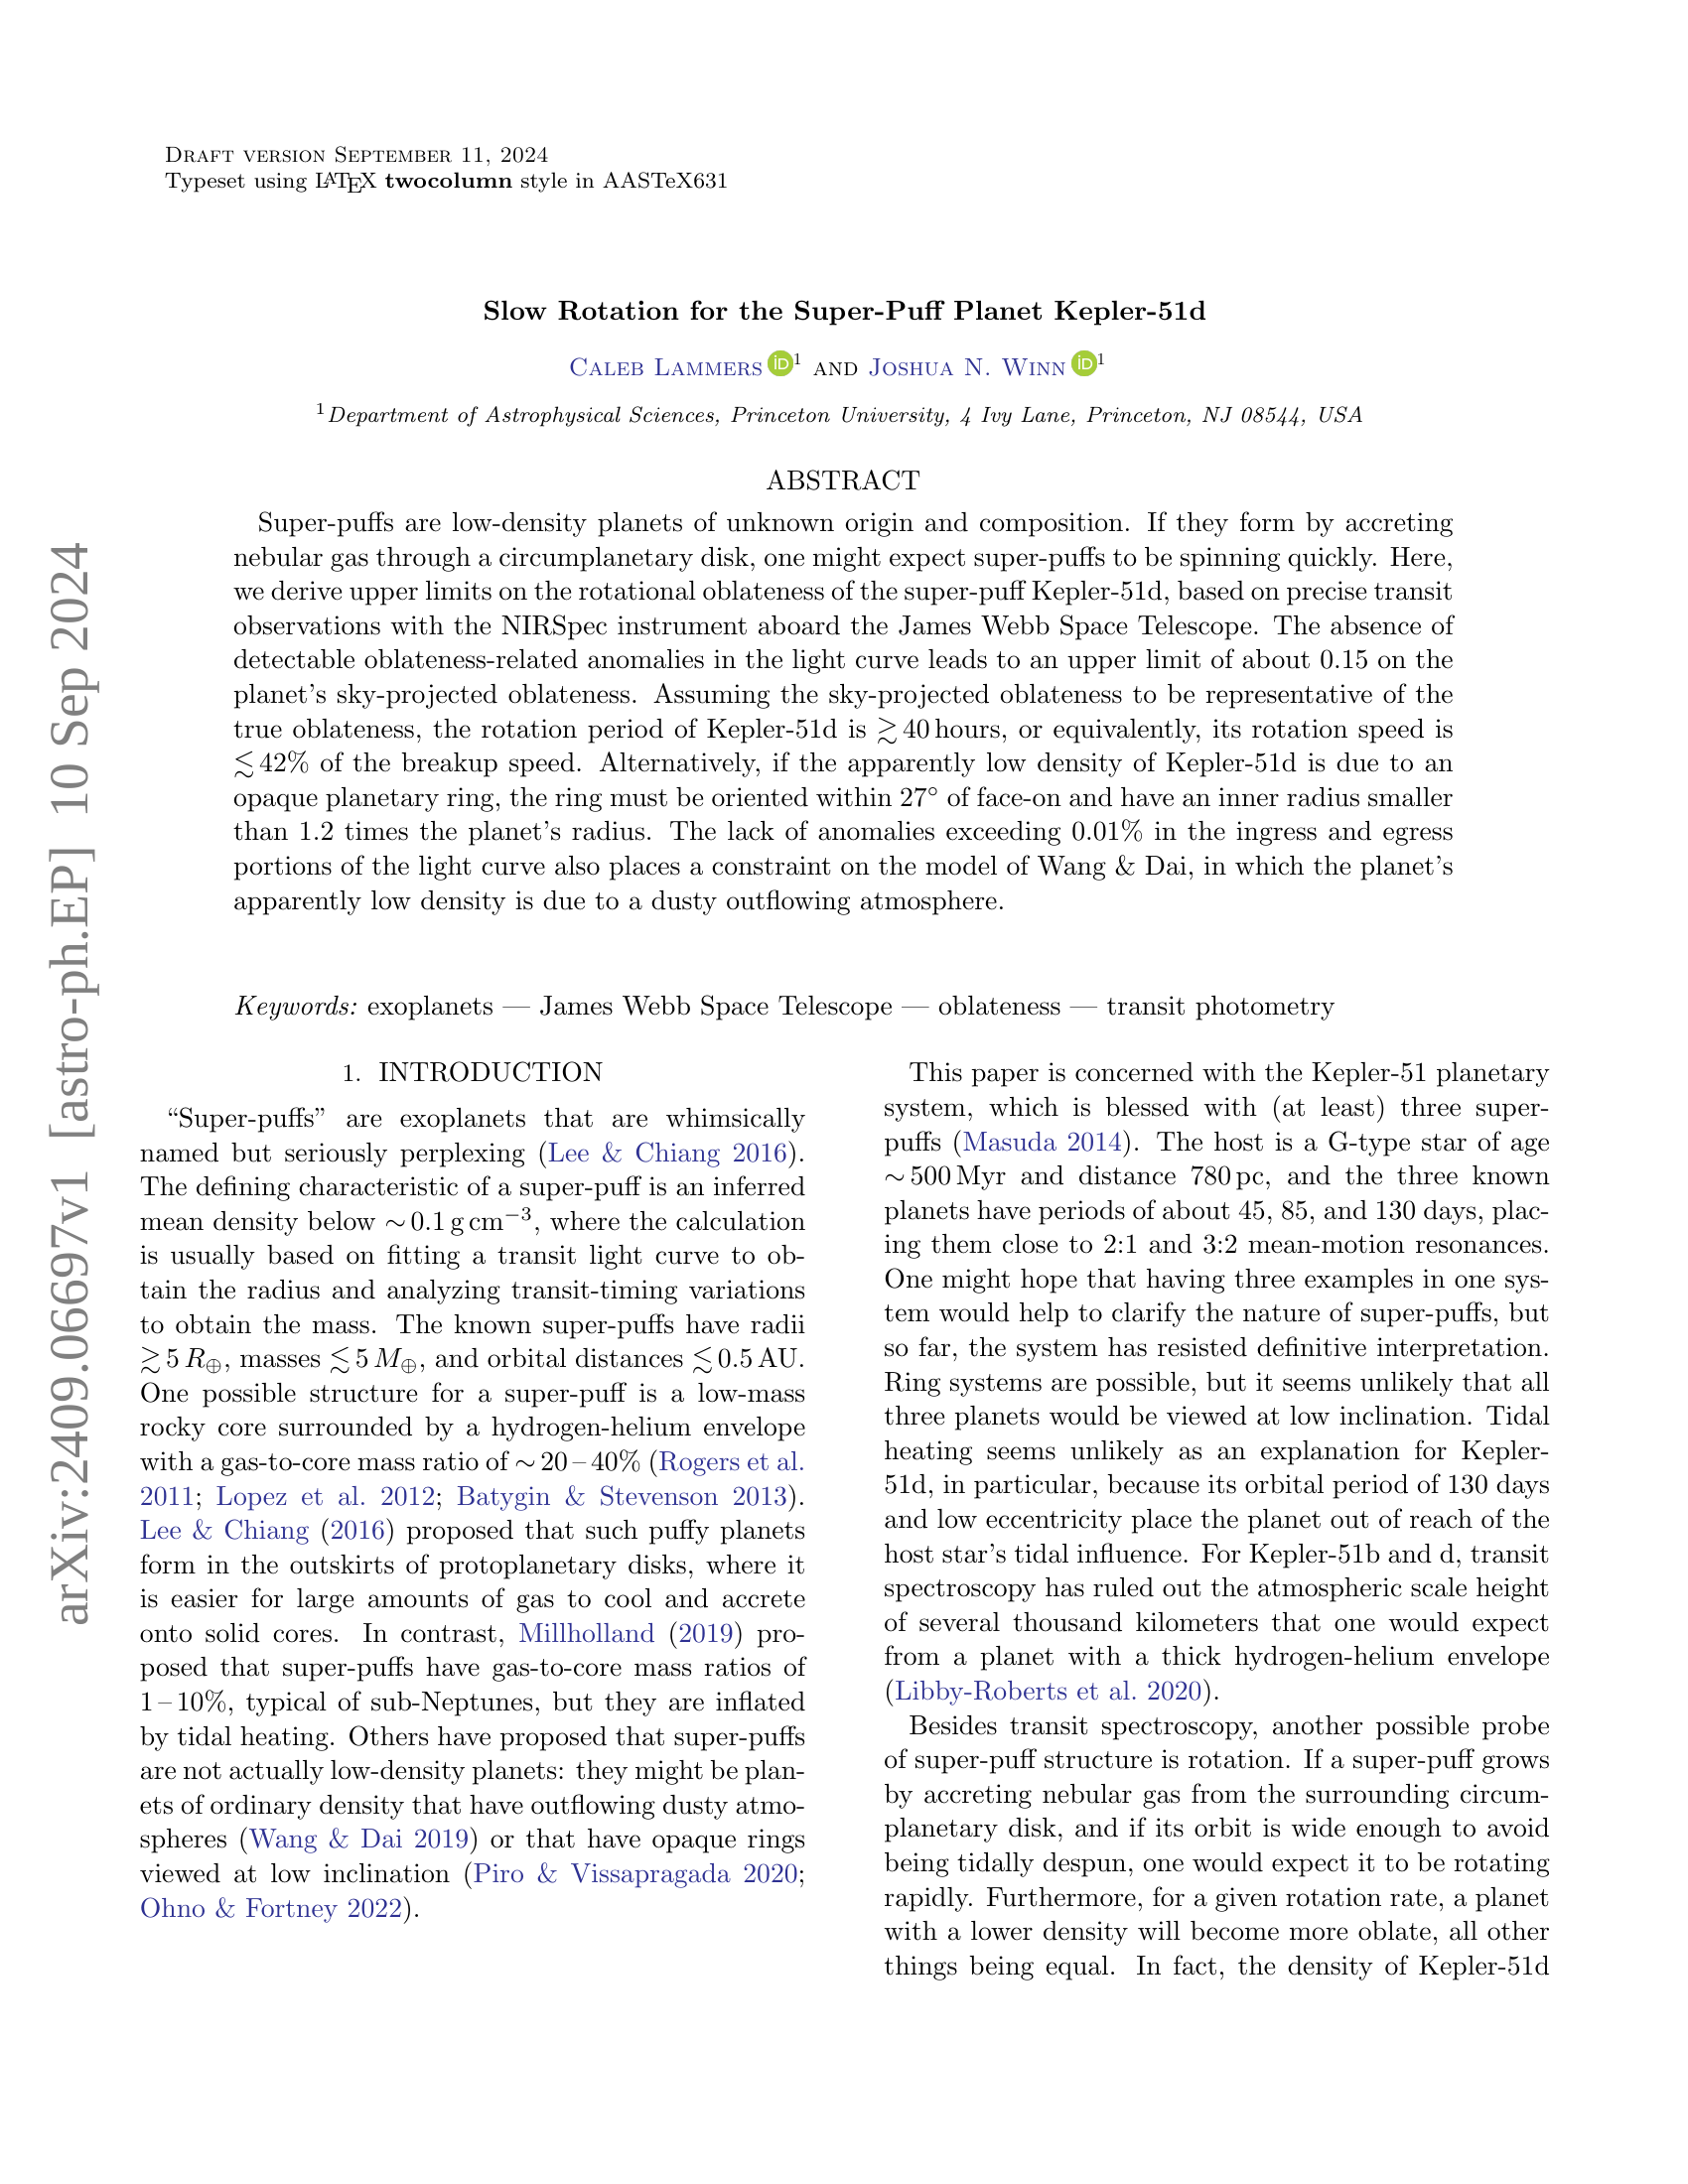

In [18]:
from IPython.display import Image,display
display(images[image_index])

## Save the Image

In [23]:
from PIL import Image

# Assuming 'img' is your image object
images[image_index].save('image1.jpg')

## Set Groq API Key

In [25]:
from google.colab import userdata
import os
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

## Synthesize response using GROQ - llava-v1.5-7b-4096-preview model

## LLaVA V1.5 7B (Preview)

* Model ID: llava-v1.5-7b-4096-preview
* Description: LLaVA (Large Language-and-Vision Assistant) is an open-source, fine-tuned multimodal model that can generate text descriptions of images, achieving impressive performance on multimodal instruction-following tasks and outperforming GPT-4 on certain benchmarks.
* Context Window: 4,096 tokens

## Limitations
* Preview Model: Llava V1.5 7B is currently in preview and should be used for experimentation.
* Image Size Limit: The maximum allowed size for a request containing an image URL as input is 20MB.
* Requests larger than this limit will return a 400 error.
* Request Size Limit (Base64 Enconded Images): The maximum allowed size for a request containing a base64 encoded image is 4MB. Requests larger than this limit will return a 413 error.
* Single Image per Request: Only one image can be processed per request. Requests with multiple images will return a 400 error.
* Single User Message per Request: Multi-turn conversations are not currently supported and only one user message is allowed per request. Requests with multiple user messages will return a 400 error.
* No System Prompt or Assistant Message: System messages and assistant messages are currently not supported. Requests including system or assistant messages will return a 400 error.
* No Tool Use: Tool Use is not currently supported. Requests with tool use or function calling will return a 400 error.
* No JSON Mode: JSON Mode is not currently supported. Requests with JSON Mode enabled will return a 400 error.

In [26]:
from groq import Groq
import base64


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "/content/image1.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

client = Groq()

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": text_query},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llava-v1.5-7b-4096-preview",
)

print(chat_completion.choices[0].message.content)

The type of star hosting the Kepler-51 planetary system is a F-type main-sequence star, known as Fp Lacertae. This star is located at roughly 3,090 light-years from Earth. Fp Lacertae is considered a B-type dwarf star, meaning it emits a relatively larger amount of intense light, and the planet Kepler 51i is seen orbitsing the star.


## Using QWEN2-VL-7B-INSTRUCT Vision Language model for response synthesis

In [27]:
# standar Inference pipeline for Qwen2-VL
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [29]:
messages = [
    {"role":"user",
     "content":[{"type":"image",
                 "image":images[image_index]
                 },
                {"type":"text","text":text_query}
              ]
    }
            ]

In [30]:
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [32]:
print(text)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>What is the type of star hosting thge kepler-51 planetary system?<|im_end|>
<|im_start|>assistant



In [33]:
image_inputs,video_inputs = process_vision_info(messages)

In [35]:
inputs = processor(text=[text],
                   images=image_inputs,
                   videos=video_inputs,
                   padding=True,
                   return_tensors="pt")
inputs = inputs.to("cuda")

In [36]:
generate_ids = model.generate(**inputs,
                              max_new_tokens=256)

In [38]:
generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generate_ids)]

In [39]:
output_text = processor.batch_decode(generated_ids_trimmed,
                                     skip_special_tokens=True,
                                     clean_up_tokenization_spaces=False)

## Output text

In [40]:
output_text

['The host star of the Kepler-51 planetary system is a G-type star.']

In [41]:
text_query  = "What is the age of the star hosting the kepler-51 planetary system?"

In [42]:
messages = [
    {"role":"user",
     "content":[{"type":"image",
                 "image":images[image_index]
                 },
                {"type":"text","text":text_query}
              ]
    }
            ]

#
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#
image_inputs,video_inputs = process_vision_info(messages)
#
inputs = processor(text=[text],
                   images=image_inputs,
                   videos=video_inputs,
                   padding=True,
                   return_tensors="pt")
inputs = inputs.to("cuda")
#
generate_ids = model.generate(**inputs,
                              max_new_tokens=256)
#
generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generate_ids)]
#
output_text = processor.batch_decode(generated_ids_trimmed,
                                     skip_special_tokens=True,
                                     clean_up_tokenization_spaces=False)
#
print(output_text[0])

The host star is a G-type star of age ~500 Myr.
